OSCILLATION OF MOTION OF PENDULUM

Damped Pendulumn
The code below is for damped motion. This means, the motion of the oscillator reduces due to an external force. 
We will use the second order differential equation.

This code defines a function damp_Pen() that takes in theta, t, damping coefficient b, acceleration due to gravity g, length of the pendulum l and mass of the bob m as inputs and returns the first derivative of theta and angular velocity.
It then defines the initial conditions for the pendulum, the time step and the time array, it uses the ODEINT function to solve the differential equation and integrate the solution over time.
Finally it plots the angular displacement as a function of time using the matplotlib library.

In [1]:
# After looking into the issue of unstable results for tensorflow backend with GPU training and large neural network models based on keras, I was finally able to get reproducible (stable) results as follows:

# Import only those libraries that would be required for setting seed and initialize a seed value
import tensorflow as tf
import os
import numpy as np
import random

SEED = 0

# Function to initialize seeds for all libraries which might have stochastic behavior
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
# Activate Tensorflow deterministic behavior
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

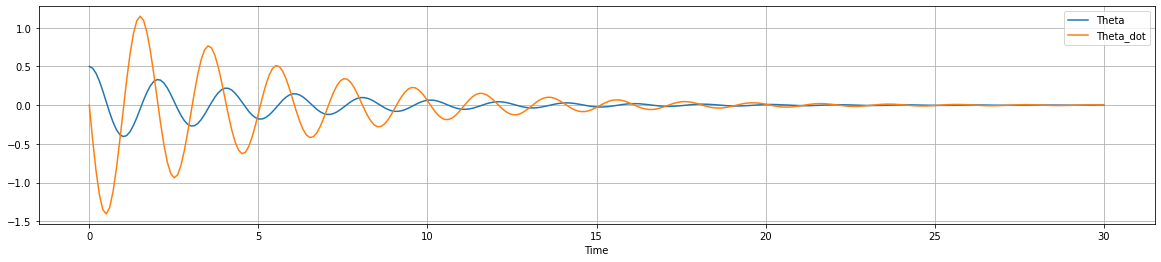

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

def damp_Pen(theta, t, b, g, l,m):
    theta1=theta[0]
    theta2=theta[1]
    dtheta1_dt=theta2
    dtheta2_dt=-((b/m)*(theta2))-((g/l)*math.sin(theta1));
    dtheta_dt=[dtheta1_dt,dtheta2_dt]
    return dtheta_dt

#the damping coeffiecient
b=0.02  

#acceleration due gravity
g= 9.81 

#the length of the string
l= 1 

#the mass of the bob
m= 0.05 

#iniial conditions
theta_0=[0.5,0]
sampling_freq = 10 #sampling frequency in Hz: 1kHz or 1000 samples per second
sim_length = 30 #time for simulation in seconds
t=np.linspace(0,sim_length,sim_length*sampling_freq)

#solving the ODE
theta = odeint(damp_Pen,theta_0,t,args=(b,g,l,m))

# Plot the results
plt.figure(figsize=(20,4))
plt.plot(t, theta[:,0],label='Theta')
plt.plot(t, theta[:,1],label='Theta_dot')
plt.xlabel('Time')
plt.legend(loc='best')
plt.grid(True)
plt.show()


<AxesSubplot:xlabel='Time'>

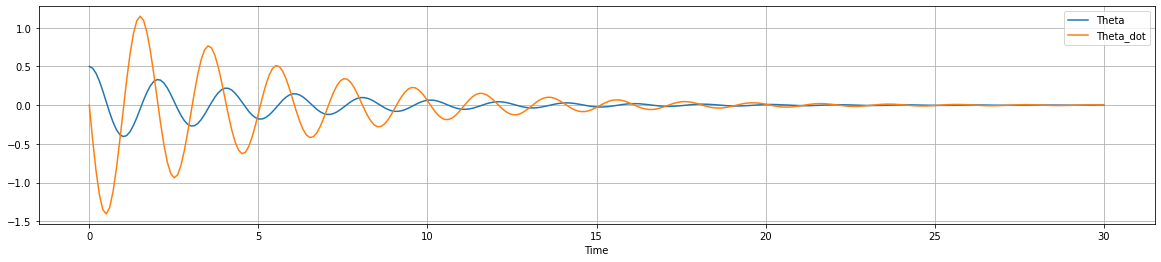

In [3]:
import pandas as pd
results = pd.DataFrame(columns=['Time', 'Theta', 'Theta_dot'])
for i in range(len(t)):
    results = results.append({'Time': t[i], 'Theta': theta[i,0], 'Theta_dot': theta[i,1]}, ignore_index=True)
results = results.set_index('Time')    
results.to_csv('pendulum_data.csv', index=['Time'])
results.plot(grid=True, figsize=(20,4))

,Theta,Theta_dot,cTheta,sTheta
Time,,,,
0.000000,0.500000,0.000000,0.877583,0.479426
0.100334,0.476808,-0.455868,0.888464,0.458946
0.200669,0.410434,-0.854672,0.916948,0.399008
0.301003,0.308361,-1.162245,0.952832,0.303497
0.401338,0.181186,-1.351251,0.983631,0.180196
...,...,...,...,...
29.598662,-0.000457,0.004019,1.000000,-0.000457
29.698997,-0.000046,0.004103,1.000000,-0.000046
29.799331,0.000353,0.003790,1.000000,0.000353


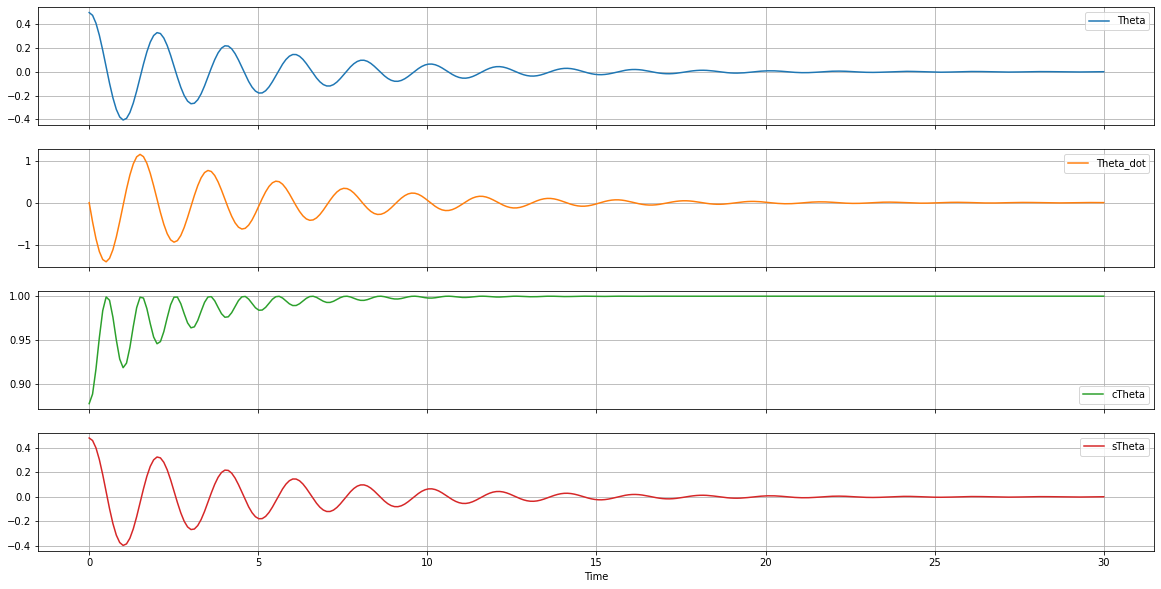

In [4]:
# Load the data
data = pd.read_csv('pendulum_data.csv')

data['cTheta'] = np.cos(data['Theta'])
data['sTheta'] = np.sin(data['Theta'])

# data['T'] = np.arctan2(data['sTheta'],data['cTheta'])
data = data.set_index('Time')
# 
data.plot(subplots=True, figsize=(20,10), grid=True)

data

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.utils import shuffle

data_min = data.min()
data_max = data.max()

data_scaler = MinMaxScaler()

print(f'min before scaling {data_min}')
print(f'max before scaling {data_max}')

data_scaled = data_scaler.fit_transform(data)
data_min = data_scaled.min()
data_max = data_scaled.max()

print(f'min after scaling {data_min}')
print(f'max after scaling {data_max}')

min before scaling Theta       -0.406522
Theta_dot   -1.405307
cTheta       0.877583
sTheta      -0.395417
dtype: float64
max before scaling Theta        0.500000
Theta_dot    1.148886
cTheta       1.000000
sTheta       0.479426
dtype: float64
min after scaling 0.0
max after scaling 1.0


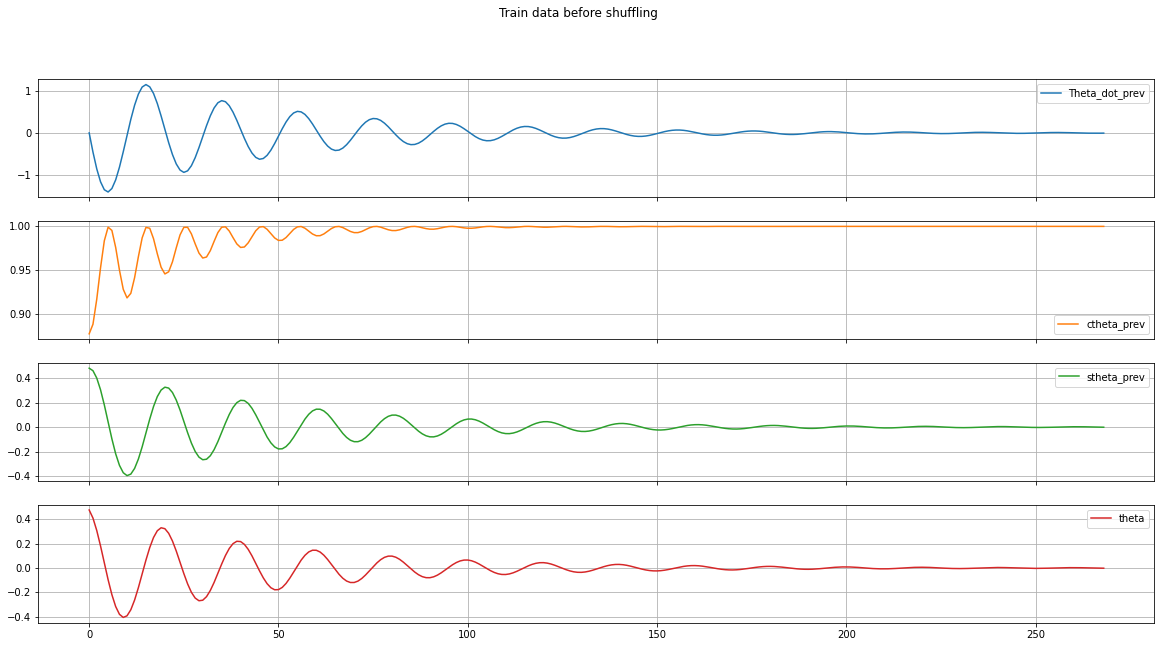

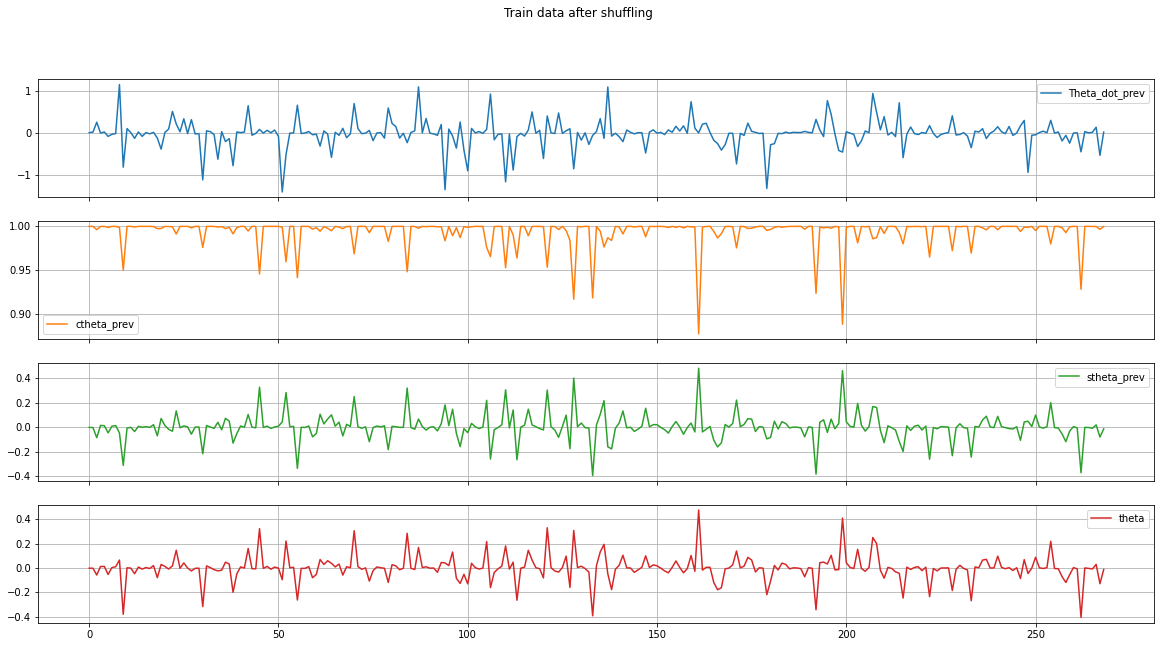

In [6]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled[:-1, 1:], data_scaled[1:, 0], test_size=0.1, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(data[['Theta_dot','cTheta', 'sTheta']].values[:-1], data['Theta'].values[1:], test_size=0.1, shuffle=False)

# pd.DataFrame(X_train).plot(grid=True, figsize=(20,10))
# pd.DataFrame(y_train).plot(grid=True, figsize=(20,10))

train_data = np.concatenate([X_train.reshape(-1,3),y_train.reshape(-1,1)], axis=-1)

train_data = pd.DataFrame(train_data)
train_data.columns = ['Theta_dot_prev','ctheta_prev','stheta_prev', 'theta']
train_data.plot(subplots=True, grid=True, figsize=(20,10), title='Train data before shuffling')

train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)

train_data.plot(subplots=True, grid=True, figsize=(20,10), title='Train data after shuffling')

X_train, y_train = train_data.values[:,:-1], train_data.values[:,-1]
train_data.shape, X_train.shape

# Reshape the input data 
X_train = X_train.reshape(-1, 3)
X_test = X_test.reshape(-1, 3)



Mean squared error:  1.4219139437130104e-08


<AxesSubplot:xlabel='Time', ylabel='Theta'>

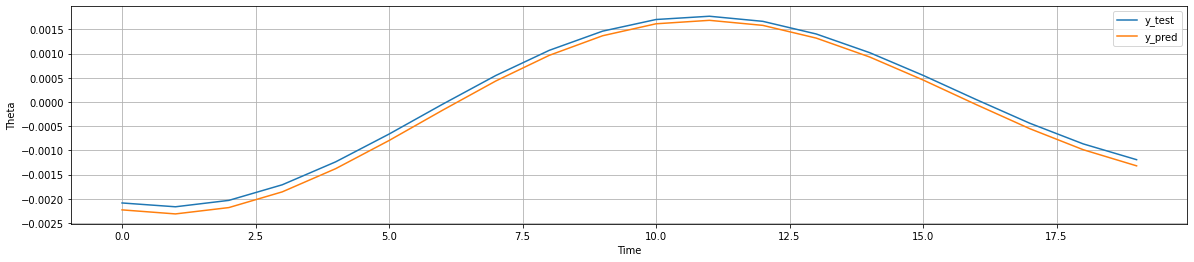

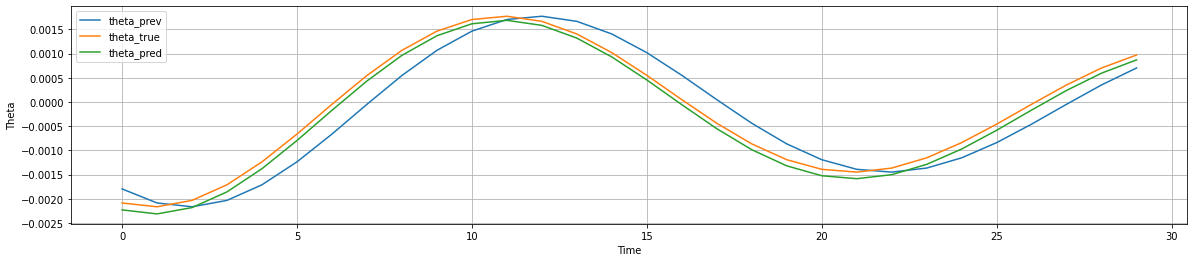

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model
reg = LinearRegression().fit(X_train, y_train)

# Predict on the test set
y_pred = reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

# y_pred = y_pred - np.mean(y_pred)

y_test_pred = pd.DataFrame([y_test.reshape(-1), y_pred.reshape(-1)]).transpose()
y_test_pred.columns = ['y_test', 'y_pred']
y_test_pred[:20].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')


X_test_ = np.arctan2(X_test[:,2],X_test[:,1])
sim_test = pd.DataFrame([X_test_.reshape(-1), y_test.reshape(-1), y_pred.reshape(-1)]).transpose()

sim_test.columns = ['theta_prev', 'theta_true', 'theta_pred']
sim_test.plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')

DO NOT EDIT THIS CELL

In [ ]:
from keras.engine.training import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax

15/15 [==============================] - 0s 2ms/step - loss: 7.4986e-08
Mean squared error:  7.498580600895366e-08
1/1 [==============================] - 0s 71ms/step
Mean squared error:  7.49860414045671e-08


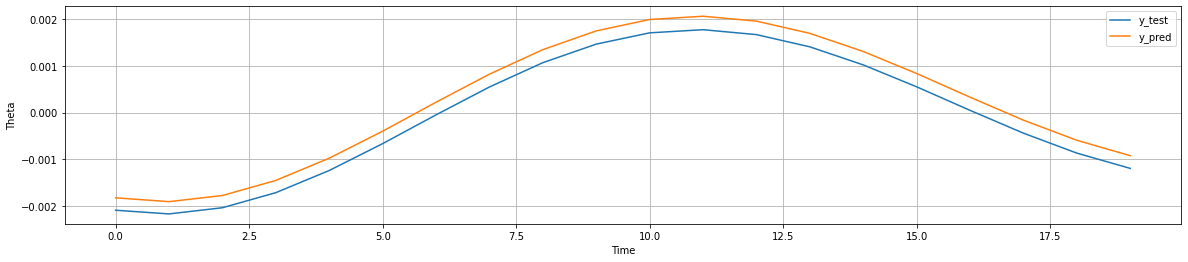

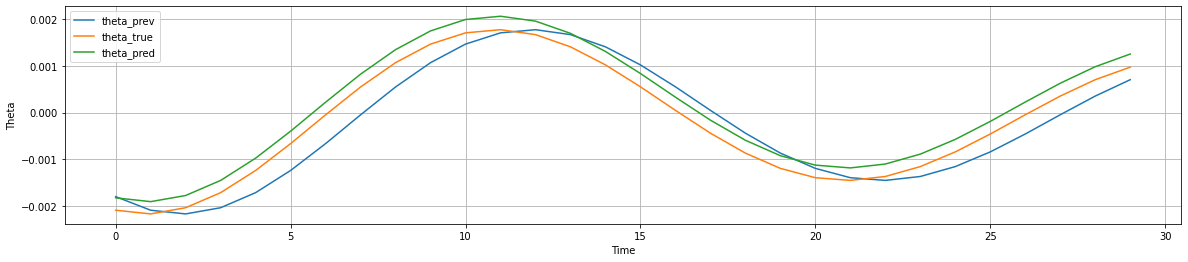

In [ ]:
# BEST SO FAR
# hidden=silu, dropout=0.1, bias=True, output=tanh, learning_rate = 0.001, batch_size=2, epochs=1000

# Create the model
model = Sequential()
model.add(Dense(512, input_dim=3, activation='silu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.01))
model.add(Dense(256, activation='silu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.01))
model.add(Dense(128, activation='silu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.01))
model.add(Dense(1, activation=tf.math.sinh, use_bias=True))

# Compile the model
model.compile(loss='mean_squared_error', optimizer= Adam(learning_rate=0.001, amsgrad=True) )

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=2, validation_split=0.01, shuffle=True, verbose=0)

# Evaluate the model
mse = model.evaluate(X_test, y_test, batch_size=2)
print('Mean squared error: ', mse)


# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

# y_pred = y_pred - np.mean(y_pred)


y_test_pred = pd.DataFrame([y_test.reshape(-1), y_pred.reshape(-1)]).transpose()
y_test_pred.columns = ['y_test', 'y_pred']
y_test_pred[:20].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')


X_test_ = np.arctan2(X_test[:,2],X_test[:,1])
sim_test = pd.DataFrame([X_test_.reshape(-1), y_test.reshape(-1), y_pred.reshape(-1)]).transpose()

sim_test.columns = ['theta_prev', 'theta_true', 'theta_pred']
sim_test[:200].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')

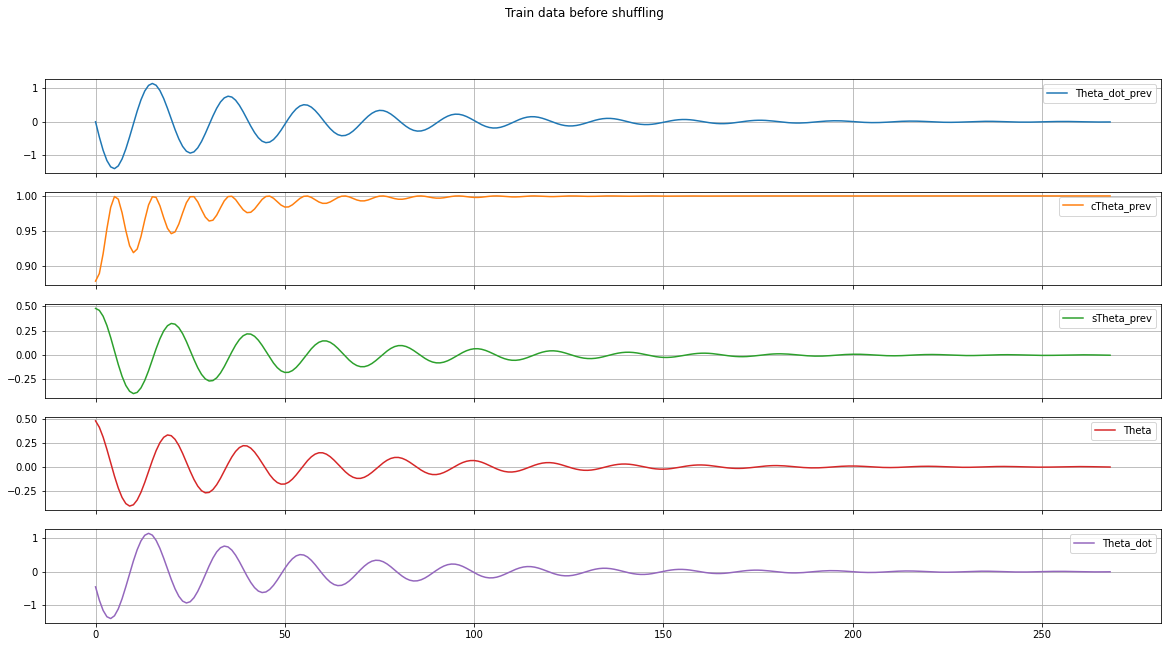

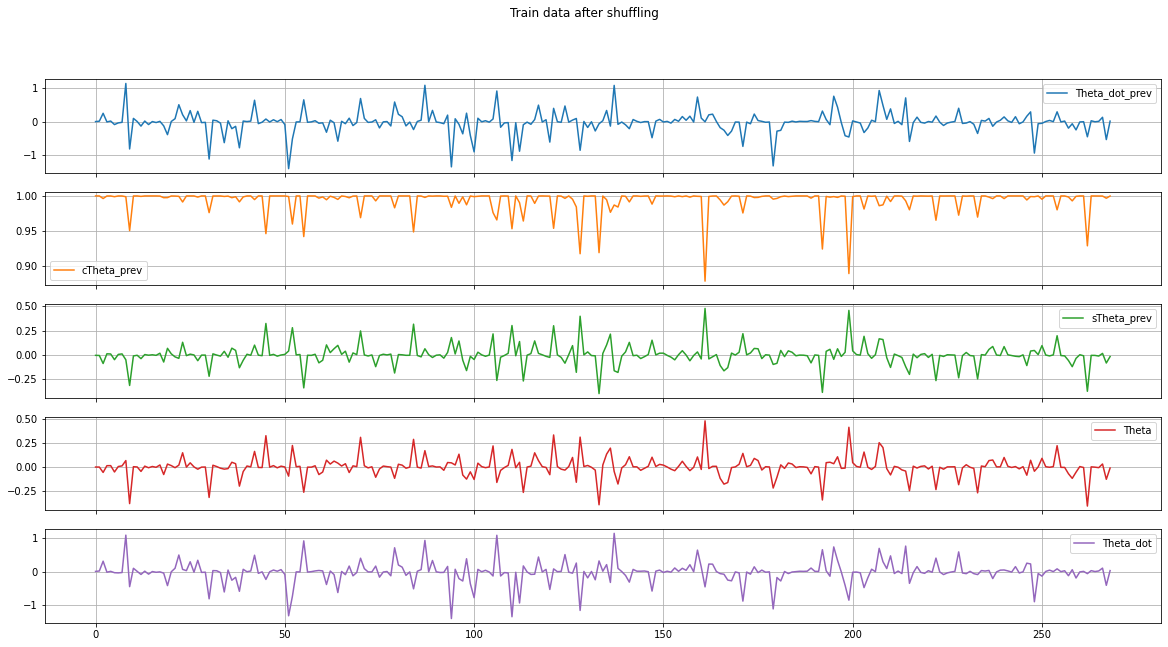

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled[:-1, 1:], data_scaled[1:, 0], test_size=0.1, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(data[['Theta_dot','cTheta', 'sTheta']].values[:-1], data[['Theta','Theta_dot']].values[1:], test_size=0.1, shuffle=False)

# pd.DataFrame(X_train).plot(grid=True, figsize=(20,10))
# pd.DataFrame(y_train).plot(grid=True, figsize=(20,10))

train_data = np.concatenate([X_train.reshape(-1,3),y_train.reshape(-1,2)], axis=-1)

train_data = pd.DataFrame(train_data)
train_data.columns = ['Theta_dot_prev','cTheta_prev','sTheta_prev', 'Theta', 'Theta_dot']
train_data.plot(subplots=True, grid=True, figsize=(20,10), title='Train data before shuffling')

train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)

train_data.plot(subplots=True, grid=True, figsize=(20,10), title='Train data after shuffling')

X_train, y_train = train_data.values[:,:-2], train_data.values[:,-2:]
train_data.shape, X_train.shape

# Reshape the input data 
X_train = X_train.reshape(-1, 3)
X_test = X_test.reshape(-1, 3)

y_train = y_train.reshape(-1, 2)
y_test = y_test.reshape(-1, 2)

Mean squared error:  7.352724311744111e-09


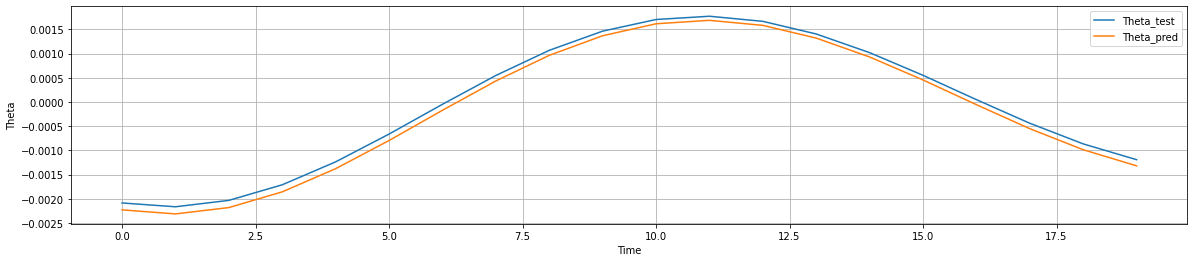

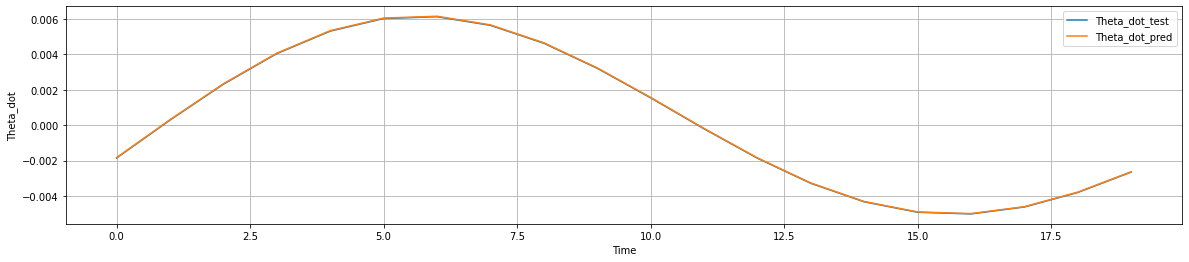

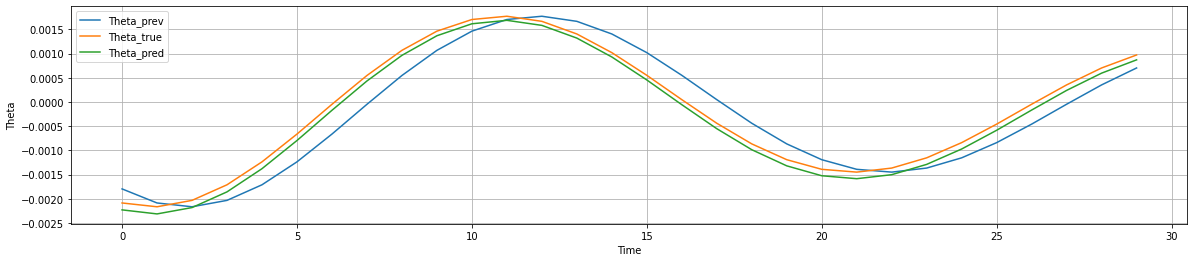

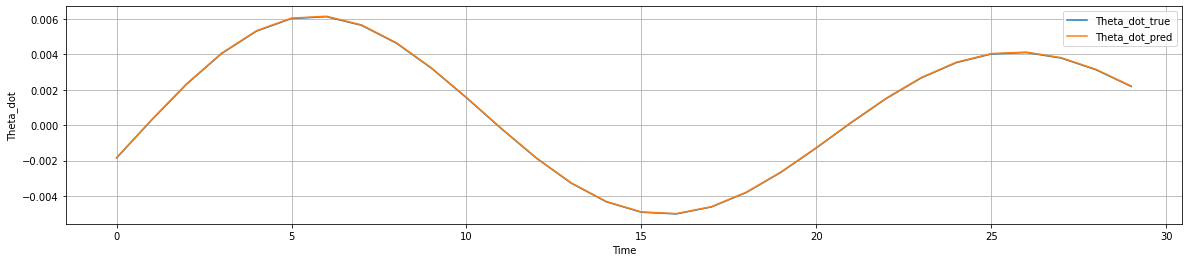

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model
reg = LinearRegression().fit(X_train, y_train)

# Predict on the test set
y_pred = reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

# y_pred = y_pred - np.mean(y_pred)

y_test_pred = pd.DataFrame(np.concatenate([y_test.reshape(-1,2), y_pred.reshape(-1,2)], axis=-1))
y_test_pred.columns = ['Theta_test', 'Theta_dot_test', 'Theta_pred', 'Theta_dot_pred']

# y_test_pred

y_test_pred[['Theta_test','Theta_pred']][:20].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')
y_test_pred[['Theta_dot_test', 'Theta_dot_pred']][:20].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta_dot')


X_test_ = np.arctan2(X_test[:,2],X_test[:,1])
sim_test = pd.DataFrame(np.hstack([X_test_.reshape(-1,1), y_test, y_pred]))
sim_test.columns = ['Theta_prev', 'Theta_true', 'Theta_dot_true', 'Theta_pred', 'Theta_dot_pred']
sim_test

sim_test[['Theta_prev', 'Theta_true', 'Theta_pred']].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')
sim_test[['Theta_dot_true', 'Theta_dot_pred']].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta_dot')

Mean squared error:  7.352724311744111e-09


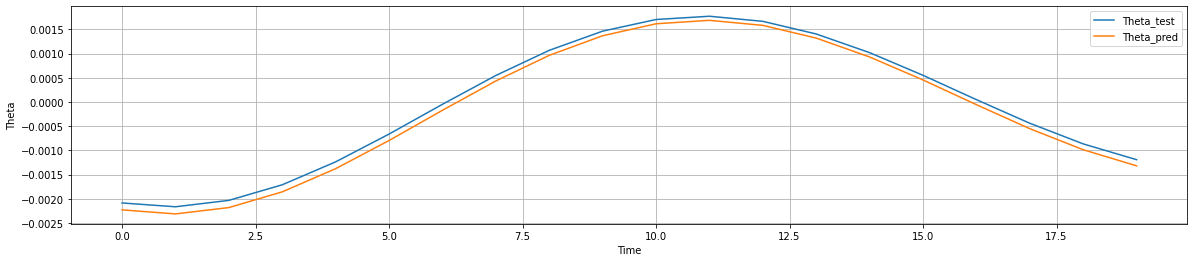

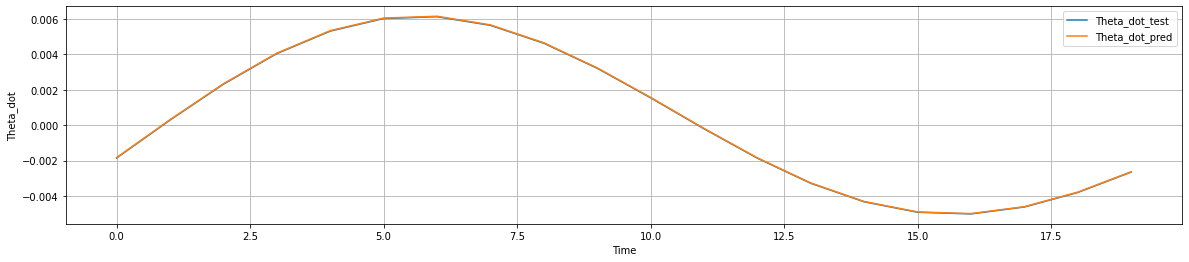

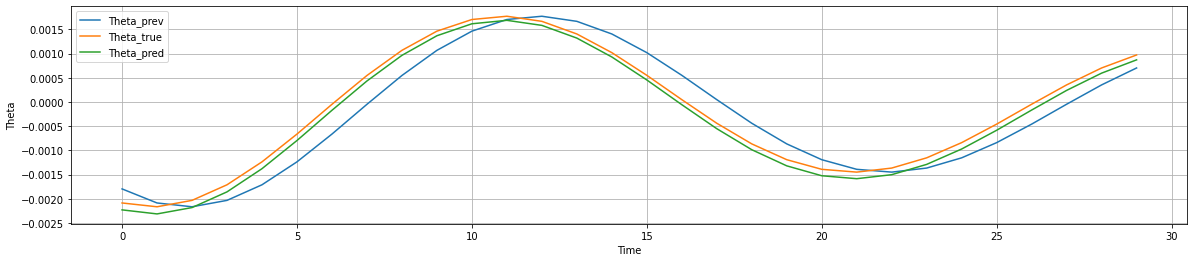

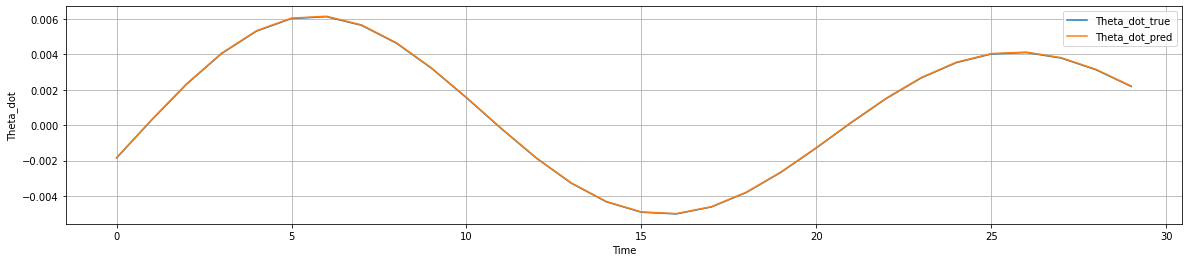

In [ ]:
# BEST SO FAR
# hidden=silu, dropout=0.1, bias=True, output=tanh, learning_rate = 0.001, batch_size=2, epochs=1000

# Create the model
model = Sequential()
model.add(Dense(512, input_dim=3, activation='silu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.01))
model.add(Dense(256, activation='silu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.01))
model.add(Dense(128, activation='silu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.01))
model.add(Dense(2, activation=tf.math.sinh, use_bias=True))

# Compile the model
model.compile(loss='mean_squared_error', optimizer= Adam(learning_rate=0.001, amsgrad=True) )

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=2, validation_split=0.01, shuffle=True, verbose=0)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

# y_pred = y_pred - np.mean(y_pred)

y_test_pred = pd.DataFrame(np.concatenate([y_test.reshape(-1,2), y_pred.reshape(-1,2)], axis=-1))
y_test_pred.columns = ['Theta_test', 'Theta_dot_test', 'Theta_pred', 'Theta_dot_pred']

# y_test_pred

y_test_pred[['Theta_test','Theta_pred']][:20].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')
y_test_pred[['Theta_dot_test', 'Theta_dot_pred']][:20].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta_dot')


X_test_ = np.arctan2(X_test[:,2],X_test[:,1])
sim_test = pd.DataFrame(np.hstack([X_test_.reshape(-1,1), y_test, y_pred]))
sim_test.columns = ['Theta_prev', 'Theta_true', 'Theta_dot_true', 'Theta_pred', 'Theta_dot_pred']
sim_test

sim_test[['Theta_prev', 'Theta_true', 'Theta_pred']].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta')
sim_test[['Theta_dot_true', 'Theta_dot_pred']].plot(grid=True, figsize=(20,4), xlabel='Time', ylabel='Theta_dot')

In [ ]:
# from tensorflow_addons.activations import mish
N=10 
drop_rate=0.0

class DNNPendulum_Model(Model):
    def __init__(self):
        super(DNN_Model, self).__init__()
        
        self.beta_values = []
        self.nn_model = Sequential([
                                Dense(512, input_dim=3, activation='silu'),
                                BatchNormalization(),
                                Dropout(0.01),
                                Dense(256, activation='silu'),
                                BatchNormalization(),
                                Dropout(0.01),
                                Dense(128, activation='silu'),
                                BatchNormalization(),
                                Dropout(0.01),
                                model.add(Dense(2, activation=tf.math.sinh, use_bias=True))])
       
    def call(self, x, **kwargs):
        
      
        x14_ = self.Out14_(x13)
        x14 = self.Out14(x13)
        x14 = tf.keras.layers.concatenate([x14,x14_], axis=-1)

        x15 = self.flatten(x14)
        x15 = self.Out15(x15)

        x = self.outputs(x15)

        return x

    def get_log(self):
        self.beta_values.append(tf.make_ndarray(tf.make_tensor_proto([self.beta1, self.beta2, self.beta3, self.beta4, self.beta5, self.beta6,
                                                     self.beta7, self.beta8, self.beta9, self.beta10, self.beta11, self.beta12, self.beta13])))
        return self.beta_values

# Testing with different Initial conditions


## State Space Simulation


,Theta_dot_SS,cTheta_SS,sTheta_SS,Theta_SS
Time,,,,
0.000000,-0.700000,1.000000,0.000000,0.000000
0.100334,-0.639098,0.997708,-0.067664,-0.067716
0.200669,-0.519386,0.992038,-0.125939,-0.126274
0.301003,-0.354901,0.985510,-0.169615,-0.170439
0.401338,-0.163282,0.980740,-0.195319,-0.196582
...,...,...,...,...
29.598662,0.000228,1.000000,0.000592,0.000592
29.698997,-0.000354,1.000000,0.000585,0.000585
29.799331,-0.000878,1.000000,0.000523,0.000523


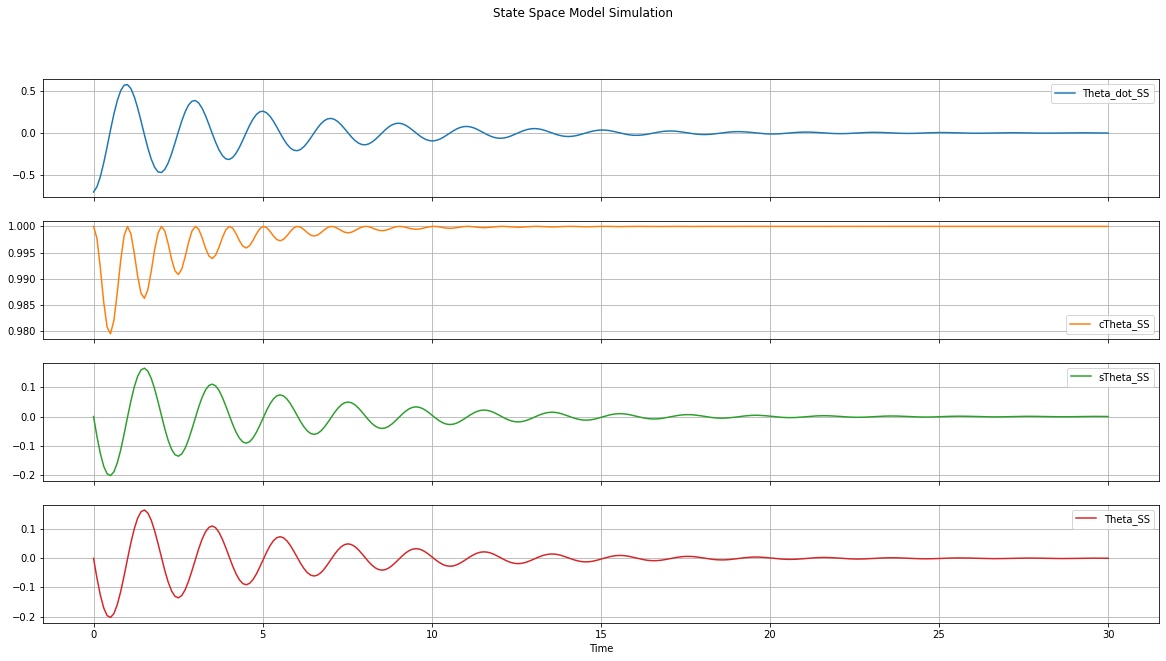

In [ ]:
theta_0=[0.,-.7]    # change initial conditions

sampling_freq = 10 #sampling frequency in Hz: 1kHz or 1000 samples per second
sim_length = 30 #time for simulation in seconds
t=np.linspace(0,sim_length,sim_length*sampling_freq)

#solving the ODE
theta = odeint(damp_Pen,theta_0,t,args=(b,g,l,m))

SS_sim_results = pd.DataFrame(np.concatenate([t.reshape(-1,1), 
                                       theta[:,1].reshape(-1,1), 
                                       np.cos(theta[:,0]).reshape(-1,1), 
                                       np.sin(theta[:,0]).reshape(-1,1), 
                                       theta[:,0].reshape(-1,1), ], axis=-1), 
                        columns=['Time', 'Theta_dot_SS', 'cTheta_SS','sTheta_SS', 'Theta_SS'])
SS_sim_results = SS_sim_results.set_index('Time')

SS_sim_results.plot(subplots=True, figsize=(20,10), grid=True, title='State Space Model Simulation')
SS_sim_results

## Feed Forward Neural Network Simulation

  0%|          | 0/299 [00:00<?, ?it/s]

,Theta_dot_NN,cTheta_NN,sTheta_NN,Theta_NN
0.000000,-0.700000,1.000000,0.000000,0.000000
0.100334,-0.639191,0.997858,-0.065414,-0.065461
0.200669,-0.521353,0.992534,-0.121965,-0.122270
0.301003,-0.359920,0.986332,-0.164773,-0.165528
0.401338,-0.172134,0.981672,-0.190580,-0.191753
...,...,...,...,...
29.598662,0.005739,1.000000,-0.000502,-0.000502
29.698997,0.005787,1.000000,-0.000433,-0.000433
29.799331,0.005766,1.000000,-0.000363,-0.000363
29.899666,0.005681,1.000000,-0.000298,-0.000298


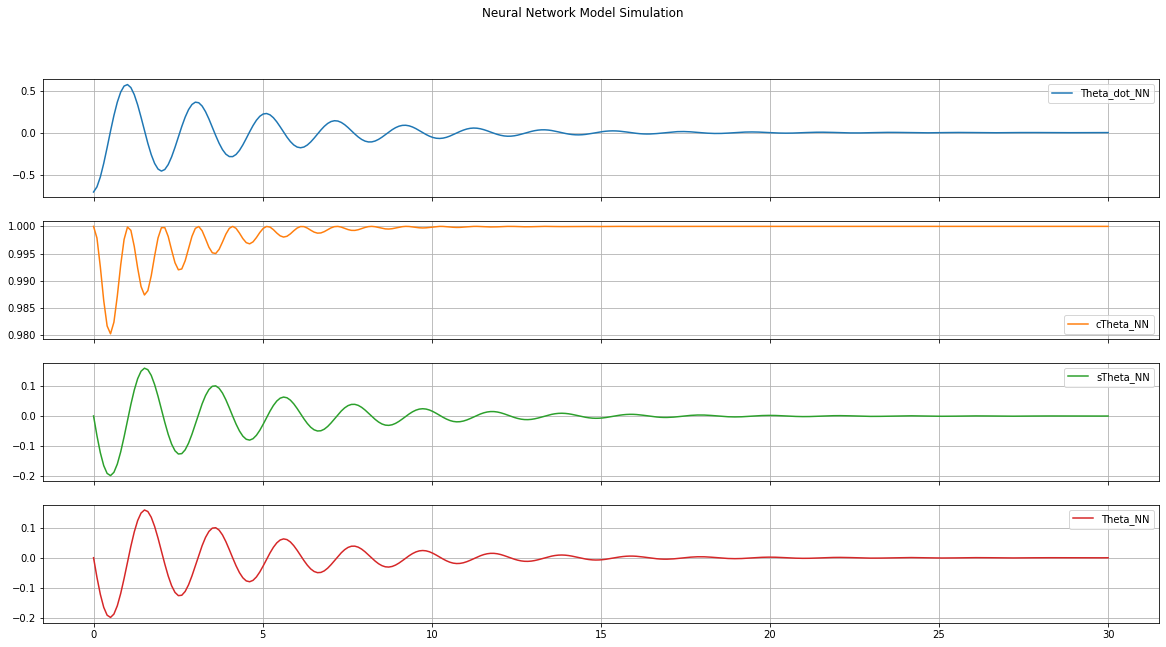

In [ ]:
from tqdm.notebook import tqdm    #Display progress bar in loops

X_Test = np.empty(shape=(len(t),3))
y_Test = np.empty(shape=(len(t),2))
X_Test[0] = np.array([theta_0[1], np.cos(theta_0[0]), np.sin(theta_0[0])]).reshape(-1,3)
y_Test[0] = theta_0

for i in tqdm(range(1, len(t))):
  y_Test[i] = model.predict(X_Test[i-1].reshape(-1,3), verbose=0)[0]
  X_Test[i] = np.array([ y_Test[i][1], np.cos(y_Test[i][0]), np.sin(y_Test[i][0])]).reshape(-1,3)

NN_sim_results = pd.DataFrame(np.hstack([X_Test, y_Test[:,0].reshape(-1,1)]))
NN_sim_results.columns = ['Theta_dot_NN','cTheta_NN','sTheta_NN', 'Theta_NN']
NN_sim_results = NN_sim_results.set_index(t)

NN_sim_results.plot(subplots=True, grid=True, figsize=(20,10), title='Neural Network Model Simulation')
NN_sim_results

,Theta_dot_SS,Theta_dot_NN,error_Theta_dot,cTheta_SS,cTheta_NN,error_cTheta,sTheta_SS,sTheta_NN,error_sTheta,Theta_SS,Theta_NN,error_Theta
0.000000,-0.700000,-0.700000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.100334,-0.639098,-0.639191,0.000092,0.997708,0.997858,-1.500758e-04,-0.067664,-0.065414,-0.002250,-0.067716,-0.065461,-0.002255
0.200669,-0.519386,-0.521353,0.001968,0.992038,0.992534,-4.963725e-04,-0.125939,-0.121965,-0.003974,-0.126274,-0.122270,-0.004005
0.301003,-0.354901,-0.359920,0.005019,0.985510,0.986332,-8.211850e-04,-0.169615,-0.164773,-0.004842,-0.170439,-0.165528,-0.004912
0.401338,-0.163282,-0.172134,0.008852,0.980740,0.981672,-9.318588e-04,-0.195319,-0.190580,-0.004739,-0.196582,-0.191753,-0.004830
...,...,...,...,...,...,...,...,...,...,...,...,...
29.598662,0.000228,0.005739,-0.005511,1.000000,1.000000,-4.914132e-08,0.000592,-0.000502,0.001093,0.000592,-0.000502,0.001093
29.698997,-0.000354,0.005787,-0.006140,1.000000,1.000000,-7.741317e-08,0.000585,-0.000433,0.001018,0.000585,-0.000433,0.001018
29.799331,-0.000878,0.005766,-0.006644,1.000000,1.000000,-7.066273e-08,0.000523,-0.000363,0.000886,0.000523,-0.000363,0.000886
29.899666,-0.001298,0.005681,-0.006978,1.000000,1.000000,-4.054491e-08,0.000412,-0.000298,0.000711,0.000412,-0.000298,0.000711


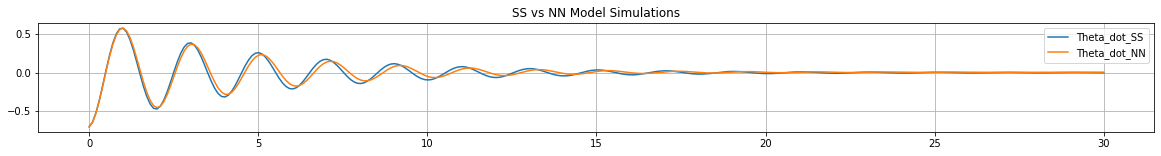

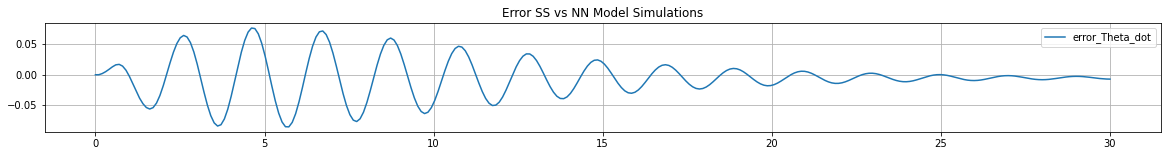

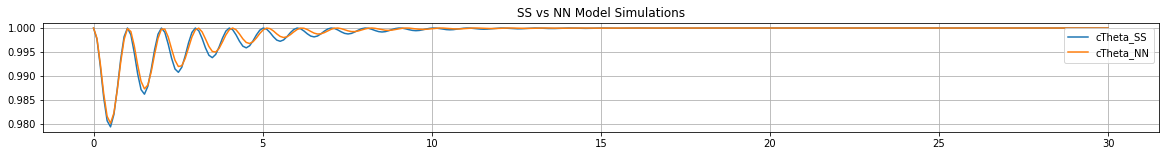

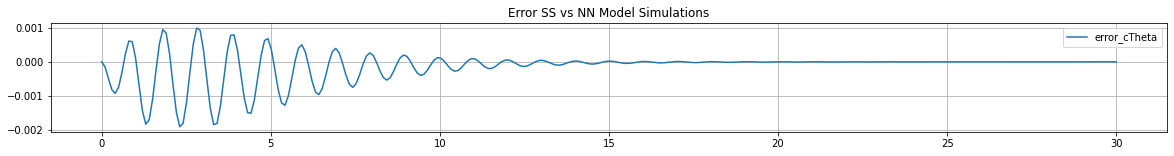

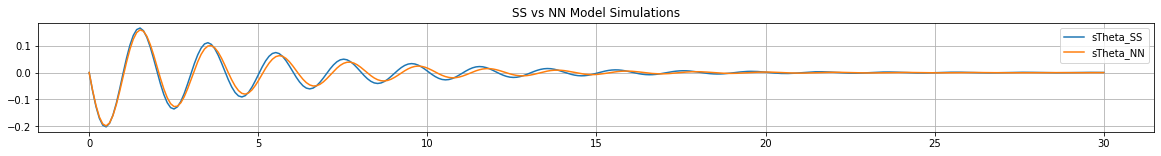

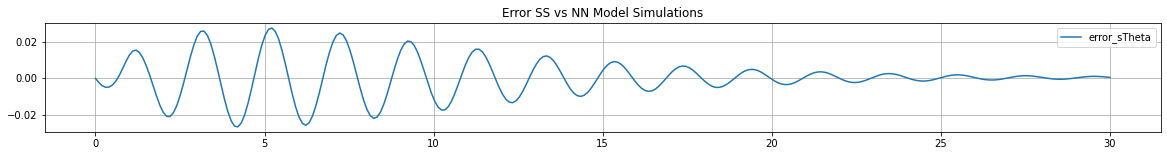

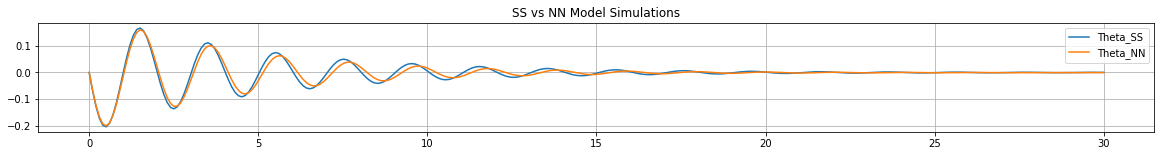

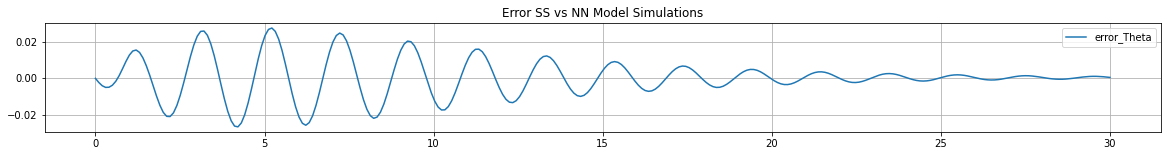

In [ ]:
Compare_results = pd.DataFrame()
Compare_results[['Theta_dot_SS','Theta_dot_NN', 'error_Theta_dot']] = pd.concat([SS_sim_results[['Theta_dot_SS']], 
                                                                                 NN_sim_results[['Theta_dot_NN']],
                                                                                 pd.DataFrame(SS_sim_results[['Theta_dot_SS']].values-NN_sim_results[['Theta_dot_NN']].values).set_index(t)], 
                                                                                axis=1)

Compare_results[['cTheta_SS','cTheta_NN', 'error_cTheta']] = pd.concat([SS_sim_results[['cTheta_SS']], 
                                                                        NN_sim_results[['cTheta_NN']],
                                                                        pd.DataFrame(SS_sim_results[['cTheta_SS']].values - NN_sim_results[['cTheta_NN']].values).set_index(t)], 
                                                                       axis=1)

Compare_results[['sTheta_SS','sTheta_NN', 'error_sTheta']] = pd.concat([SS_sim_results[['sTheta_SS']], 
                                                                        NN_sim_results[['sTheta_NN']],
                                                                        pd.DataFrame(SS_sim_results[['sTheta_SS']].values - NN_sim_results[['sTheta_NN']].values).set_index(t)], 
                                                                       axis=1)

Compare_results[['Theta_SS','Theta_NN', 'error_Theta']] = pd.concat([SS_sim_results[['Theta_SS']], 
                                                                     NN_sim_results[['Theta_NN']],
                                                                     pd.DataFrame(SS_sim_results[['Theta_SS']].values - NN_sim_results[['Theta_NN']].values).set_index(t)], 
                                                                    axis=1)

Compare_results[['Theta_dot_SS','Theta_dot_NN']].plot(subplots=False, grid=True, figsize=(20,2), title='SS vs NN Model Simulations')
Compare_results[['error_Theta_dot']].plot(subplots=False, grid=True, figsize=(20,2), title='Error SS vs NN Model Simulations')
Compare_results[['cTheta_SS','cTheta_NN']].plot(subplots=False, grid=True, figsize=(20,2), title='SS vs NN Model Simulations')
Compare_results[['error_cTheta']].plot(subplots=False, grid=True, figsize=(20,2), title='Error SS vs NN Model Simulations')
Compare_results[['sTheta_SS','sTheta_NN']].plot(subplots=False, grid=True, figsize=(20,2), title='SS vs NN Model Simulations')
Compare_results[['error_sTheta']].plot(subplots=False, grid=True, figsize=(20,2), title='Error SS vs NN Model Simulations')
Compare_results[['Theta_SS','Theta_NN']].plot(subplots=False, grid=True, figsize=(20,2), title='SS vs NN Model Simulations')
Compare_results[['error_Theta']].plot(subplots=False, grid=True, figsize=(20,2), title='Error SS vs NN Model Simulations')
Compare_results

This code defines the function pendulum() which takes in the variables y, t, l and g as input and returns the first derivative of theta and angular velocity.
It then defines the initial conditions for the pendulum, the time step and the time array, it uses the ODEINT function to solve the differential equation and integrate the solution over time.
It then plots the angular displacement as a function of time using the matplotlib library.
The initial angle, angular velocity and length of the pendulum can be adjusted to see the effect of these parameters on the motion of the pendulum.

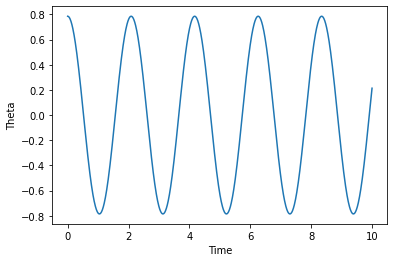

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the pendulum dynamics
def pendulum(y, t, l, g):
    theta, omega = y
    dydt = [omega, -(g/l)*np.sin(theta)]
    return dydt

# Initial conditions
theta_0 = np.pi/4 # initial angle
omega_0 = 0 # initial angular velocity
y_0 = [theta_0, omega_0]

# Simulation parameters
l = 1 # length of pendulum
g = 9.81 # acceleration due to gravity
t = np.linspace(0, 10, 1000) # time

# Solve the ODE
sol = odeint(pendulum, y_0, t, args=(l, g))

# Plot the results
plt.plot(t, sol[:, 0])
plt.xlabel('Time')
plt.ylabel('Theta')
plt.show()


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Define the pendulum dynamics
def pendulum(y, t, l, g):
    theta, omega = y
    dydt = [omega, -(g/l)*np.sin(theta)]
    return dydt

# Initial conditions
theta_0 = np.pi/4 # initial angle
omega_0 = 0 # initial angular velocity
y_0 = [theta_0, omega_0]

# Simulation parameters
l = 1 # length of pendulum
g = 9.81 # acceleration due to gravity
t = np.linspace(0, 10, 1000) # time

# Solve the ODE
sol = odeint(pendulum, y_0, t, args=(l, g))

# Extract theta values
theta = sol[:, 0]

# Add a column of ones for the constant term in the linear regression
X = np.ones((len(theta), 2))
X[:, 1] = t

# Fit the linear regression model
reg = LinearRegression().fit(X, theta)

# Print the model coefficients
print(reg.intercept_, reg.coef_[1])


0.055395352705455786 -0.016018439771492136


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Define the pendulum dynamics
def pendulum(theta, t, l, g):
    omega = -(g/l)*np.sin(theta)
    return omega

# Create training data
l = 1 # length of pendulum
g = 9.81 # acceleration due to gravity
theta_values = np.linspace(0, np.pi, 100) # angles
t_values = np.linspace(0, 10, 100) # time
omega_values = pendulum(theta_values, t_values, l, g) # angular velocity

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(theta_values.reshape(-1, 1))
y_train = omega_values

# Build the neural network
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, input_dim=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200)

# Predict angular velocity for a given angle
theta_test = np.array([[np.pi/4]])
theta_test = scaler.transform(theta_test)
omega_pred = model.predict(theta_test)
print("Predicted angular velocity:", omega_pred)


Epoch 1/200
4/4 [==============================] - 0s 3ms/step - loss: 48.2319
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 48.1578
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 48.0823
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 48.0083
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 47.9355
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 47.8605
Epoch 7/200
4/4 [==============================] - 0s 5ms/step - loss: 47.7864
Epoch 8/200
4/4 [==============================] - 0s 2ms/step - loss: 47.7111
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 47.6383
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 47.5632
Epoch 11/200
4/4 [==============================] - 0s 2ms/step - loss: 47.4884
Epoch 12/200
4/4 [==============================] - 0s 2ms/step - loss: 47.4126
Epoch 13/200
4/4 [==============================]